In [1]:
import numpy as np
from itertools import cycle
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime as dt
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/regional-mom6/")
from pathlib import Path
import regional_mom6 as rm
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46611,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:33779,Total threads: 4
Dashboard: /proxy/34495/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:39557,


# TTide domain

In [2]:

## Choose your coordinates and the name of your experiment


yextent = [-56,-26]
xextent = [142,180]
expt_name = "full-10"

# 
daterange = ["2010-01-01 00:00:00", "2020-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/tasman-tides/rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = Path(f"/g/data/nm03/ab8992/glorys-download/tenyears")
# tmpdir = f"/home/149/ab8992/tasman-tides/rundirs/full-20/inputdir/forcing"
# tmpdir = "/home/149/ab8992/tasman-tides/rundirs/mkic/archive/output000/"
## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)

In [3]:
expt = rm.experiment(
    longitude_extent = xextent,
    latitude_extent = yextent,
    date_range = daterange,
    resolution = 0.1,  ## Resolution
    number_vertical_layers = 100,      ## #zlayers
    layer_thickness_ratio = 20,       ## dz ratio
    depth = 5500,    ## Max depth of ocean
    mom_run_dir = rundir,
    mom_input_dir = inputdir,
    toolpath_dir = toolpath
)



In [4]:
varnames = {"time":"time","y":"latitude","x":"longitude",
     "zl":"depth","eta":"zos","u":"uo","v":"vo",
     "tracers":{"salt":"so","temp":"thetao"}}



expt.initial_condition(
    tmpdir / "ic_unprocessed.nc",
    varnames,
    arakawa_grid="A"
    )

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-clx-0468
--------------------------------------------------------------------------


INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.


In [5]:
# for i,orientation in enumerate(["south","north","west","east"]):
#     expt.setup_rectangular_boundary(
#         tmpdir / (orientation + "_unprocessed.nc"),
#         varnames,
#         orientation,
#         i + 1
#         )
    

expt.rectangular_boundaries(
        tmpdir,
        varnames,
        boundaries = ["south", "north", "west", "east"],
        arakawa_grid = "A"
        )

Processing south boundary...Done.
Processing north boundary...Done.
Processing west boundary...Done.
Processing east boundary...Done.


In [6]:
expt.setup_era5("/g/data/rt52/era5/single-levels/reanalysis")


In [8]:
expt.tidy_bathymetry(positive_down=False)

Reading in regridded bathymetry to fix up metadata...done.


In [ ]:
expt.setup_bathymetry(
    bathymetry_path='/g/data/v45/ab8992/synbath2/SYNBATH_V1.2.nc',
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='z',
    minimum_layers=1
    )



Begin regridding bathymetry...

If this process hangs it means that the chosen domain might be too big to handle this way. After ensuring access to appropriate computational resources, try calling ESMF directly from a terminal in the input directory via

mpirun ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var elevation --dst_var elevation --netcdf4 --src_regional --dst_regional

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run 'tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.
Regridding in parallel: True


--------------------------------------------------------------------------

  Local host:   gadi-cpu-clx-0468
  Local device: mlx5_0
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   gadi-cpu-clx-0468
  Local device: mlx5_0
--------------------------------------------------------------------------


In [5]:
experiment.FRE_tools(layout = (30,30))


AttributeError: FRE_tools not found. Available methods and attributes are: ['_make_hgrid', '_make_vgrid', 'bathymetry_property', 'boundaries', 'change_MOM_parameter', 'configure_cpu_layout', 'create_empty', 'date_range', 'depth', 'era5', 'expt_name', 'find_MOM6_rectangular_orientation', 'get_glorys_rectangular', 'hgrid', 'hgrid_type', 'initial_condition', 'latitude_extent', 'layer_thickness_ratio', 'layout', 'longitude_extent', 'minimum_depth', 'mom_input_dir', 'mom_run_dir', 'number_vertical_layers', 'ocean_mask', 'ocean_state_boundaries', 'read_MOM_file_as_dict', 'repeat_year_forcing', 'resolution', 'run_FRE_tools', 'segments', 'setup_bathymetry', 'setup_boundary_tides', 'setup_era5', 'setup_initial_condition', 'setup_ocean_state_boundaries', 'setup_run_directory', 'setup_single_boundary', 'tidal_constituents', 'tides_boundaries', 'tidy_bathymetry', 'toolpath_dir', 'vgrid', 'vgrid_type', 'write_MOM_file', 'write_config_file']

In [8]:
expt.setup_run_directory("",using_payu=True)

Number of CPUs required:  1435


## Add Tides to an Existing Run
Offline I've copied all the inputs from the ttide-20 run. All that this notebook does is use the out-of-the-box NWA scripts to add tidal constituents. I'll then need to go back to the MOM_input file from my old tide test to rectify the new one 

In [1]:
import os
import xarray as xr
os.chdir("/home/149/ab8992/cosima_regional/development/withtides/regional-mom6/")
os.listdir()
import boundary_tides as bt

In [9]:
import xarray as xr
bathy = xr.open_dataset("/home/149/ab8992/tasman-tides/rundirs/full-10/inputdir/topog.nc")

bathy["depth"] = bathy["depth"].fillna(10)

bathy.to_netcdf("/home/149/ab8992/tasman-tides/rundirs/full-10/inputdir/topog_nanfilled.nc",mode = "w")

In [2]:
## VERBATIM COPY OLD CODE AND SEE WHAT HAPPENS

# """
# constituents in TPXO9:
# con =
# "m2  ",  0
# "s2  ",  1
# "n2  ",  2
# "k2  ",  3
# "k1  ",  4
# "o1  ",  5
# "p1  ",  6
# "q1  ",  7
# "mm  ",  8
# "mf  ",  9
# "m4  ", 10
# "mn4 ", 11
# "ms4 ", 12
# "2n2 ", 13
# "s1  "  14
# """
# Use these constituents:
# (MOM6 does not currently support m4, mn4, ms4, 2n2, or s1.)
# constituents = range(0, 10)

constituents = [0]

# Hardcoded for my ttide domain!!! 

horizontal_subset = dict(ny=slice(200,380), nx=slice(850,1100))

# Path to tpxo9.v1 data
tpxo_dir = '/g/data/nm03/TPXO'
expt_name = "full-10"
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/"

# Save output here
output_dir = inputdir + "/forcing"

# Setup NWA boundaries
hgrid = xr.open_dataset(inputdir + '/hgrid.nc')
# segments taken from nwa25_obc.py
segments = [
    bt.Segment(1, 'south', hgrid, output_dir=output_dir),
    bt.Segment(2, 'north', hgrid, output_dir=output_dir),
    bt.Segment(3, 'west', hgrid, output_dir=output_dir),
    bt.Segment(4, 'east', hgrid, output_dir=output_dir)
]
# reload(bt)
bt.write_tpxo(constituents, tpxo_dir, segments, horizontal_subset,"tpxo9.v1.nc")

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-clx-2835
--------------------------------------------------------------------------
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/x

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect

In [1]:
import os
os.chdir("/home/149/ab8992/cosima_regional/crocodile/regional-mom6")
import regional_mom6 as rm
from pathlib import Path

In [2]:
yextent = [-56,-26]
xextent = [142,180]
expt_name = "full-10"

# 
daterange = ["2010-01-01 00:00:00", "2020-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/tasman-tides/rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = Path(f"/g/data/nm03/ab8992/glorys-download/tenyears")
# tmpdir = f"/home/149/ab8992/tasman-tides/rundirs/full-20/inputdir/forcing"
# tmpdir = "/home/149/ab8992/tasman-tides/rundirs/mkic/archive/output000/"
## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables


experiment = rm.experiment(
    date_range = daterange,
    resolution = 0.1,  ## Resolution,
    number_vertical_layers = 100,      ## #zlayers
    layer_thickness_ratio = 20,       ## dz ratio
    depth = 5500,    ## Max depth of ocean
    mom_run_dir = rundir,
    mom_input_dir = inputdir,
    hgrid_type = "from_file",
    minimum_depth = 10
)

This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.


In [3]:
experiment.tidy_bathymetry()


Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... done.


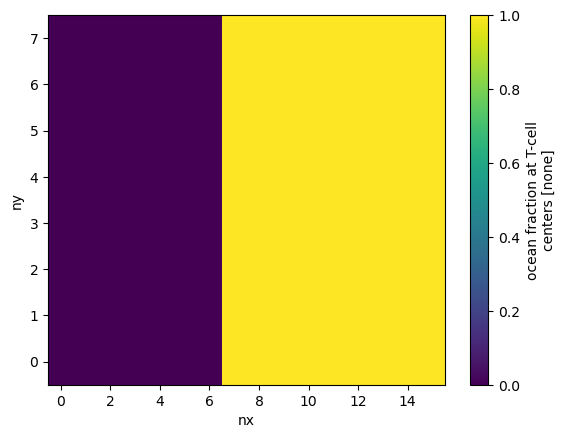

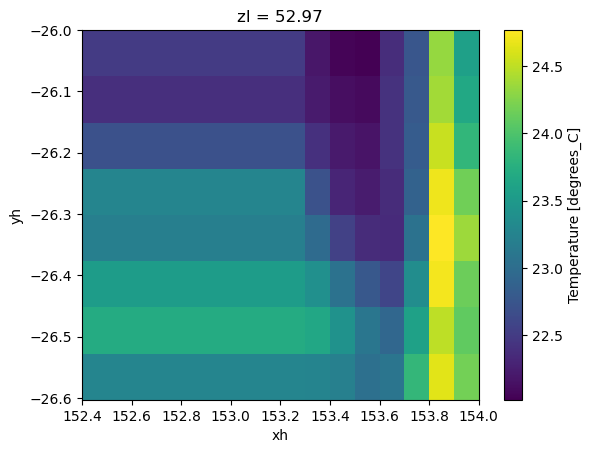

In [33]:
import matplotlib.pyplot as plt

eta = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/full-10/forcing/init_eta.nc")
tracers = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/full-10/forcing/init_tracers.nc")
mask = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/full-10/ocean_mask.nc")
mask.mask.isel(nx = slice(104,120),ny = slice(390,None)).plot()
plt.figure()
tracers.temp.isel(zl = 9).isel(xh = slice(104,120),yh = slice(390,None)).plot()


In [28]:
## NEed to fill in the phase 0 values!
import numpy as np
for segment in range(4):
    segment += 1
    d = xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-10/forcing/tz_00{segment}.nc")
    for i in ["phase","amp"]:
    # d[f"zamp_segment_00{segment}"].plot()
        d[f"z{i}_segment_00{segment}"] = d[f"z{i}_segment_00{segment}"].where(d[f"z{i}_segment_00{segment}"] != 0,np.nan).ffill(f"nx_segment_00{segment}").bfill(f"nx_segment_00{segment}").ffill(f"ny_segment_00{segment}").bfill(f"ny_segment_00{segment}")

    d.to_netcdf(f"/g/data/nm03/ab8992/ttide-inputs/full-10/forcing/tz_00{segment}_filled.nc",unlimited_dims = "time",mode = "w")


    d = xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-10/forcing/tu_00{segment}.nc")
    for i in ["u","v"]:
    # d[f"zamp_segment_00{segment}"].plot()
        d[f"{i}amp_segment_00{segment}"] = d[f"{i}amp_segment_00{segment}"].where(
            d[f"{i}amp_segment_00{segment}"] != d[f"{i}amp_segment_00{segment}"].roll({f"nx_segment_00{segment}" : 1},roll_coords = False)
            ,np.nan)
        
        d[f"{i}amp_segment_00{segment}"] = d[f"{i}amp_segment_00{segment}"].ffill(f"nx_segment_00{segment}").bfill(f"nx_segment_00{segment}").ffill(f"ny_segment_00{segment}").bfill(f"ny_segment_00{segment}")

    d.to_netcdf(f"/g/data/nm03/ab8992/ttide-inputs/full-10/forcing/tu_00{segment}_filled.nc",unlimited_dims = "time",mode = "w")

    # plt.figure()

In [59]:
d.nx_segment_002

<xarray.DataArray 'nx_segment_002' (nx_segment_002: 761)> Size: 6kB
array([  0,   1,   2, ..., 758, 759, 760])
Coordinates:
    lon_segment_002  (nx_segment_002) float64 6kB ...
    lat_segment_002  (nx_segment_002) float64 6kB ...
Dimensions without coordinates: nx_segment_002

In [58]:
mask.nx

<xarray.DataArray 'nx' (nx: 380)> Size: 3kB
array([  0,   1,   2, ..., 377, 378, 379])
Dimensions without coordinates: nx

In [ ]:
d = xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-10/forcing/tu_002.nc")
d.vphase_segment_002.isel(nx_segment_002 = 22).values

array([[[1.5906955]]])

In [52]:
mask = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/full-10/ocean_mask.nc")
mask.mask.isel(ny = -1,nx = slice(109,115)).values

array([0., 0., 1., 1., 1., 1.])

In [12]:
ls /g/data/

hh5/  nm03/  v45/  x77/
